# January, 13th 2020

**Motivation**: Combining datasets using CanonicalCorrelation Analysis (CCA). Can we find latent dimensions using CCA that is shared between different datasets, and then map data from neuron space to this shared latent space?<br>
**Result**: Not yet clear, some preliminary results show that this is possible.  However, thorough analysis is needed to understand this shared space.  It still doesn't work convincingly.

In [4]:
import random
import numpy as np
list(np.array([0, 2, 3]))

[0, 2, 3]

In [1]:
# HIDE CODE


# imports
import os
import sys
import h5py
import pickle
import random
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import rcca
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

# load data
dirs_dict = get_dirs()

## CCA analysis

TODO

In [2]:
from typing import Tuple, Union

def _load_target_nontarget(h_load_file: str):
    target_dffs, nontarget_dffs = {}, {}
    target_labels, nontarget_labels = {}, {}
    
    f = h5py.File(h_load_file, 'r')
    for name in f:
        behavior = f[name]['behavior']
        passive = f[name]['passive']

        good_cells_b = np.array(behavior["good_cells"], dtype=int)
        good_cells_p = np.array(passive["good_cells"], dtype=int)
        good_cells = set(good_cells_b).intersection(set(good_cells_p))
        good_cells = sorted(list(good_cells))

        dff = np.array(behavior['dff'], dtype=float)[..., good_cells]
        nt, ntrials, nc = dff.shape

        trial_info = {}
        for k, v in behavior["trial_info"].items():
            trial_info[k] = np.array(v, dtype=int)

        target_indxs = np.where(trial_info['target'])[0]
        nontarget_indxs = np.where(trial_info['nontarget'])[0]

        target_dffs[name] = dff[:, target_indxs, :]
        nontarget_dffs[name] = dff[:, nontarget_indxs, :]

        target_labels[name] = trial_info['hit'][target_indxs]
        nontarget_labels[name] = trial_info['correctreject'][nontarget_indxs]
    f.close()
    
    raw_data = {
        'target_dffs': target_dffs,
        'nontarget_dffs': nontarget_dffs,
        'target_labels': target_labels,
        'nontarget_labels': nontarget_labels,
    }
    return raw_data

def augment_data(
    x: np.ndarray,
    y: np.ndarray,
    nb_end_samples: int,
    sigma: float = 1.0,
    rng: np.random.RandomState = None,):
    
    nb_samples, nb_features = x.shape

    if nb_end_samples - nb_samples <= 0:
        output = {
            'x_aug': x[:nb_end_samples],
            'y_aug': y[:nb_end_samples],
            'noise': None,
            'indxs': None,
        }
        return output
    else:
        nb_repeats, nb_extra_samples = nb_end_samples//nb_samples, nb_end_samples%nb_samples

    indxs = np.arange(nb_samples)
    x_aug, y_aug = tuple(map(dc, [x, y]))

    for _ in range(1, nb_repeats):
        indxs = np.concatenate([indxs, np.arange(nb_samples)])
        x_aug = np.concatenate([x_aug, x])
        y_aug = np.concatenate([y_aug, y])

    rng = np.random.RandomState(42) if rng is None else rng
    if nb_extra_samples > 0:
        extra_indxs = rng.choice(range(nb_samples), size=nb_extra_samples, replace=True)
        indxs = np.concatenate([indxs, extra_indxs])
        x_aug = np.concatenate([x_aug, x[extra_indxs]])
        y_aug = np.concatenate([y_aug, y[extra_indxs]])

    noise = np.random.randn(*x_aug.shape) * x.std(0) * sigma
    noise[:nb_samples] = 0.0

    augmented = {
        'x_aug': x_aug + noise,
        'y_aug': y_aug,
        'noise': noise,
        'indxs': indxs,
    }
    return augmented

    
def prepare_data(
    h_load_file: str,
    timepoint: int = 45,
    nb_min_samples: int = -1,
    nb_end_samples: int = None,
    augment: bool = False,
    sigma: float = 0.0,
    xv_folds: int = 10,
    random_state: int = 42,):
    
    raw_data = _load_target_nontarget(h_load_file)
    rng = np.random.RandomState(random_state)
    
    train_data, test_data = {}, {}
    train_labels, test_labels = {}, {}
    for key, val in raw_data['target_dffs'].items():
        x = val[timepoint]
        num_samples = len(x)
        if num_samples < nb_min_samples:
            continue

        labels = raw_data['target_labels'][key]
        if not augment:
            x = x[:nb_min_samples]
            labels = labels[:nb_min_samples]

        ### TODDO: floor or ceil?
            
        pos_indxs = np.where(labels == 0)[0]
        neg_indxs = np.where(labels == 1)[0]
        pos_tst_indxs = rng.choice(pos_indxs, size=int(np.ceil(len(pos_indxs)/xv_folds)), replace=False)
        neg_tst_indxs = rng.choice(neg_indxs, size=int(np.ceil(len(neg_indxs)/xv_folds)), replace=False)
        tst_indxs = np.concatenate([pos_tst_indxs, neg_tst_indxs])
        trn_indxs = np.delete(range(len(labels)), tst_indxs)
        assert not set(tst_indxs).intersection(set(trn_indxs))

        test_data[key] = x[tst_indxs]
        train_data[key] = x[trn_indxs]
        test_labels[key] = labels[tst_indxs]
        train_labels[key] = labels[trn_indxs]
    
    aug_train_data = {}
    aug_train_labels = {}
    if augment:
        for key, x in train_data.items():
            y = train_labels[key]
            augmented = augment_data(
                x=x,
                y=y,
                nb_end_samples=nb_end_samples,
                sigma=sigma,
                rng=rng,
            )
            aug_train_data[key] = augmented['x_aug']
            aug_train_labels[key] = augmented['y_aug']
    
    output = {
        'aug_train_data': aug_train_data,
        'aug_train_labels': aug_train_labels,
        'train_data': train_data,
        'train_labels': train_labels,
        'test_data': test_data,
        'test_labels': test_labels,
    }
    return output

In [3]:
import rcca
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

import random
from tqdm.notebook import tqdm

In [4]:
max_components = 100
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=False,
        nb_min_samples=100,
        random_state=seed,
    )
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(train_data.values()))
        ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 4,
            'sigma': [np.nan] * 4,
            'n_components': [n_components] * 4,
            'metric': ['mcc', 'f1', 'balacc', 'ev'],
            'value': [mcc, balacc, f1, np.mean([item.max(0).mean() for item in ev])],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

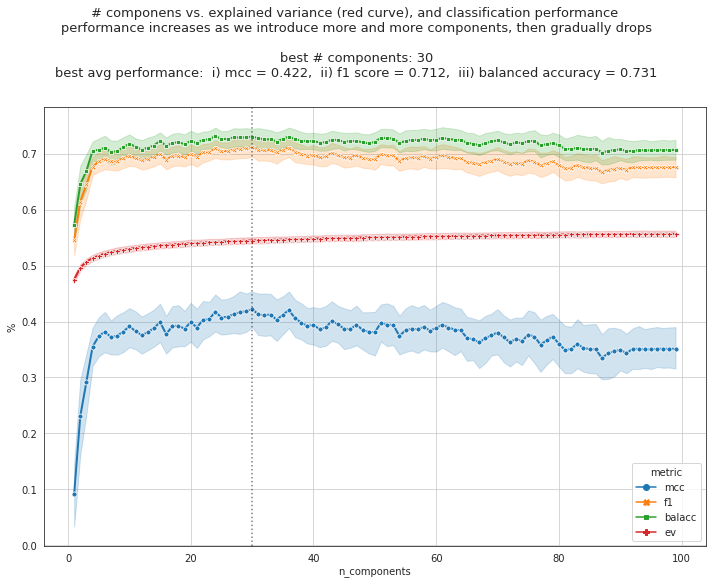

In [5]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [6]:
selected_df

,seed,sigma,n_components,metric,value
116,1,NaN,30,mcc,0.382679
512,2,NaN,30,mcc,0.478061
908,4,NaN,30,mcc,0.488662
1304,8,NaN,30,mcc,0.368924
1700,16,NaN,30,mcc,0.382679
2096,32,NaN,30,mcc,0.392532
2492,64,NaN,30,mcc,0.482527
2888,128,NaN,30,mcc,0.448464
3284,256,NaN,30,mcc,0.309343
3680,512,NaN,30,mcc,0.341797


### now aug

In [7]:
max_components = 40
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=True,
        sigma=0.3,
        nb_end_samples=130,
        nb_min_samples=100,
        random_state=seed,
    )
    aug_train_data = output['aug_train_data']
    # aug_train_labels = output['aug_train_labels']
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(aug_train_data.values()))
        # ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 3,
            'sigma': [np.nan] * 3,
            'n_components': [n_components] * 3,
            'metric': ['mcc', 'f1', 'balacc'],
            'value': [mcc, balacc, f1],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

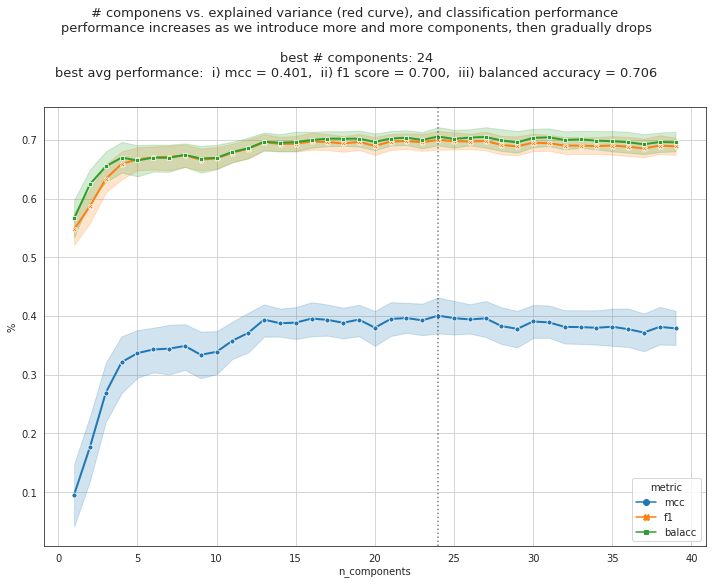

In [8]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [9]:
selected_df

,seed,sigma,n_components,metric,value
69,1,NaN,24,mcc,0.288944
186,2,NaN,24,mcc,0.432512
303,4,NaN,24,mcc,0.513300
420,8,NaN,24,mcc,0.269125
537,16,NaN,24,mcc,0.316980
654,32,NaN,24,mcc,0.465849
771,64,NaN,24,mcc,0.379787
888,128,NaN,24,mcc,0.470824
1005,256,NaN,24,mcc,0.459796
1122,512,NaN,24,mcc,0.396239


### more aug

In [10]:
max_components = 40
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=True,
        sigma=0.3,
        nb_end_samples=300,
        nb_min_samples=100,
        random_state=seed,
    )
    aug_train_data = output['aug_train_data']
    # aug_train_labels = output['aug_train_labels']
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(aug_train_data.values()))
        ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 4,
            'sigma': [np.nan] * 4,
            'n_components': [n_components] * 4,
            'metric': ['mcc', 'f1', 'balacc', 'ev'],
            'value': [mcc, balacc, f1, np.mean([item.max(0).mean() for item in ev])],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

/usr/local/lib/python3.8/dist-packages/rcca/__init__.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ccomp = np.array(ccomp)


ValueError: operands could not be broadcast together with shapes (13,1) (14,1) 

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
selected_df

### more aug / all data

In [18]:
max_components = 40
seeds = [np.power(2, i) for i in range(20)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=True,
        sigma=0.3,
        nb_end_samples=150,
        nb_min_samples=30,
        random_state=seed,
    )
    aug_train_data = output['aug_train_data']
    # aug_train_labels = output['aug_train_labels']
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(aug_train_data.values()))
        # ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 3,
            'sigma': [np.nan] * 3,
            'n_components': [n_components] * 3,
            'metric': ['mcc', 'f1', 'balacc'],
            'value': [mcc, balacc, f1],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

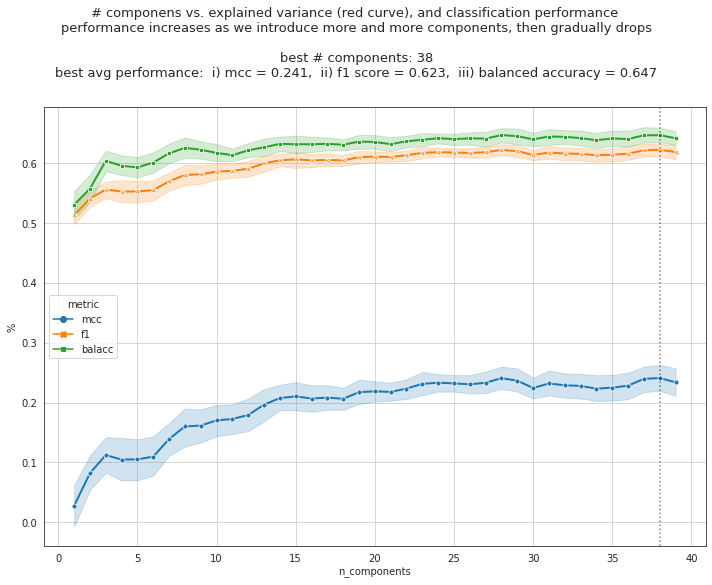

In [19]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [20]:
selected_df

,seed,sigma,n_components,metric,value
111,1,NaN,38,mcc,0.196640
228,2,NaN,38,mcc,0.168664
345,4,NaN,38,mcc,0.216517
462,8,NaN,38,mcc,0.273217
579,16,NaN,38,mcc,0.252466
696,32,NaN,38,mcc,0.315904
813,64,NaN,38,mcc,0.208521
930,128,NaN,38,mcc,0.164668
1047,256,NaN,38,mcc,0.208509
1164,512,NaN,38,mcc,0.260438


## Discussion
### ???